## Final Project Submission

Please fill out:
* Student name: Devin Belden
* Student pace: full time
* Scheduled project review date/time: Wed, Jan 15, 2020, 2:00 PM - 3:00 PM MST
* Instructor name: James Irving, Ph.D
* Blog post URL: https://devinbelden.github.io/the_ocarina_of_time_series

# Business Case

For this project, we attempt to parse through real estate sales data throughout the US and nail down the five best ZIP codes in which to invest. The definition of "best" we have chosen for this project is to have a high return on investment (ROI) while having a narrow confidence band for that ROI. Specifically, the heuristic we use to penalize a wide confidence band is

$$\large \text{Score} = \begin{cases}\dfrac{10R}{\log(P_H-P_L+2)}, & \text{if } R>0, \newline
\phantom{----}R, & \text{if } R\leq 0.\end{cases}$$

where $R$ is the predicted ROI as a percentage, and $P_H$ and $P_L$ are the highest and lowest prediction values within the 95% confidence band at the end of the prediction time period, respectively. Further reading on this heuristic, including the derivation, can be found in the Appendix.

Note: The last datapoint in the Zillow dataset is April 2018. All of our predictions are made up to and including April 2019.

# Importing/Exploring Data

First, let's import relevant packages, as well as import the dataset.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-poster')
pd.set_option('display.max_columns', 0)

zillow = pd.read_csv('zillow_data.csv')

zillow.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,...,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,999100,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,211100.0,205700.0,200900.0,196800.0,193600.0,191400.0,190400.0,190800.0,192700.0,196000.0,201300.0,207400.0,212200.0,214600.0,215100.0,213400.0,210200.0,206100.0,202100.0,198800.0,196100.0,194100.0,193400.0,...,251400,253000,255200,258000,261200,264700,268400,271400,273600,275200,276400,277000,277900,280000,282600,285400,288400,290800,292000,292800,293700,295200,297000,299000,300800,301800,302800,304400,306200,307000,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,195400.0,193000.0,191800.0,191800.0,193000.0,195200.0,198400.0,202800.0,208000.0,213800.0,220700.0,227500.0,231800.0,233400.0,233900.0,233500.0,233300.0,234300.0,237400.0,242800.0,250200.0,258600.0,268000.0,...,301700,302400,303600,306200,309100,311900,314100,316300,319000,322000,324300,326100,327300,327000,327200,328500,329800,330000,329000,327800,326700,325500,324700,324500,323700,322300,320700,320000,320000,320900,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,502200.0,500000.0,497900.0,496300.0,495200.0,494700.0,494900.0,496200.0,498600.0,502000.0,507600.0,514900.0,522200.0,529500.0,537900.0,546900.0,556400.0,566100.0,575600.0,584800.0,593500.0,601600.0,610100.0,...,1176400,1174600,1178500,1185700,1192900,1198800,1200400,1198900,1200200,1207400,1218600,1226600,1230700,1235400,1241300,1245700,1247000,1246700,1245700,1246000,1247700,1252900,1260900,1267900,1272600,1276600,1280300,1282500,1286000,1289000,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,77800.0,77900.0,77900.0,77800.0,77800.0,77800.0,77800.0,77800.0,77900.0,78100.0,78200.0,78400.0,78600.0,78800.0,79000.0,79100.0,79200.0,79300.0,79300.0,79300.0,79400.0,79500.0,79500.0,79600.0,...,114700,115000,115000,115200,115600,115900,115600,115400,115400,115500,115800,116300,116200,115600,115000,114500,114200,114000,114000,113900,114100,114900,115700,116300,116900,117300,117600,118000,118600,118900,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


We'll need to convert this data such that it has a datetime index. We can do this using the `melt()` method built into pandas, as well as the `to_datetime()` and `set_index()` methods.

In [2]:
def melt_data(df): #formerly called it melt_data_student with REED
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [3]:
df = melt_data(zillow)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [4]:
df['Month'] = pd.to_datetime(df['Month'], errors='coerce')
df = df.set_index('Month', drop=False)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
Month,,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


It's worth mentioning that RegionID and RegionName seem to be two sides of the same coin, but in reality, RegionName is just the ZIP code. It's unknown what RegionID means, but we'll keep it in the dataframe anyway. It might come in handy later.

For RegionName, however, let's just rename that column ZipCode. 

In [5]:
df.rename(columns={'RegionName': 'ZipCode'}, inplace=True)

# EDA and Data Visualization

As part of EDA, we'll need to plot graphs of different ZIP codes' prices as functions of time. Let's create a new dataframe re-indexed by `ZipCode` and write a function to plot ZIP codes of our choice.

In [6]:
df2 = df.groupby('ZipCode').resample('MS').asfreq()
df2

RegionID  ZipCode  ...      Month MeanValue
ZipCode Month                          ...                     
1001    1996-04-01     58196     1001  ... 1996-04-01  113100.0
        1996-05-01     58196     1001  ... 1996-05-01  112800.0
        1996-06-01     58196     1001  ... 1996-06-01  112600.0
        1996-07-01     58196     1001  ... 1996-07-01  112300.0
        1996-08-01     58196     1001  ... 1996-08-01  112100.0
...                      ...      ...  ...        ...       ...
99901   2017-12-01    100478    99901  ... 2017-12-01  291900.0
        2018-01-01    100478    99901  ... 2018-01-01  294200.0
        2018-02-01    100478    99901  ... 2018-02-01  297500.0
        2018-03-01    100478    99901  ... 2018-03-01  302100.0
        2018-04-01    100478    99901  ... 2018-04-01  305100.0

[3744704 rows x 9 columns]

## Preliminary Visualization of Raw Data

For preliminary data visualization, let's write a function that takes in a list of ZIP codes as input, and outputs a plot of the `MeanValue` over time.

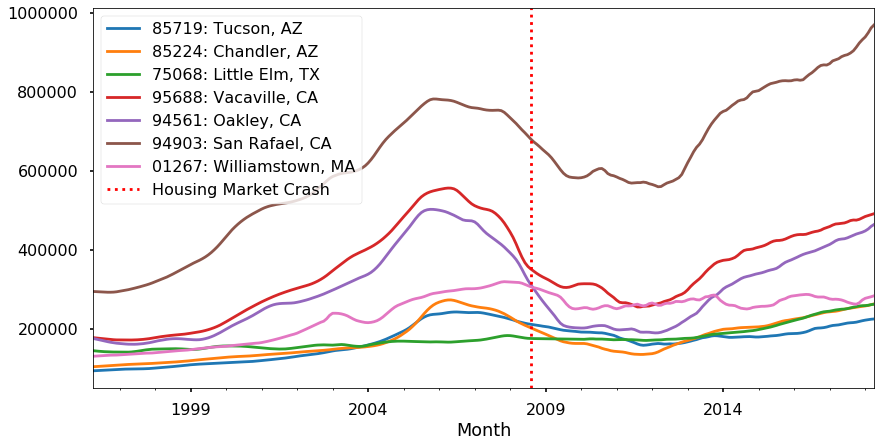

In [7]:
def plot_ts(zipcodes=[1001], df=df2, col='MeanValue', show_crash=False):
    
    fig, ax = plt.subplots(figsize=(14,7))
    
    for zipcode in zipcodes:
        ts = df[col].loc[zipcode]
        if zipcode/10000 < 1:
            label='0'+str(zipcode)+': '+df['City'][zipcode][0]+', '+df['State'][zipcode][0]
        else:
            label=str(zipcode)+': '+df['City'][zipcode][0]+', '+df['State'][zipcode][0]
        ts.plot(label=label, ax=ax)
        
    if show_crash:
        ax.axvline('08-2008', label='Housing Market Crash', color='red', ls=':')
    
    ax.legend()
    plt.show()

plot_ts(zipcodes=[85719, 85224,75068,95688,94561,94903,1267], show_crash=True)

Here, we've defined August of 2008 as the start of the real estate crash. As can be seen from the above visualization, nearly all of the ZIP codes follow a similar trend over time. Isolating one ZIP code, the blue line:

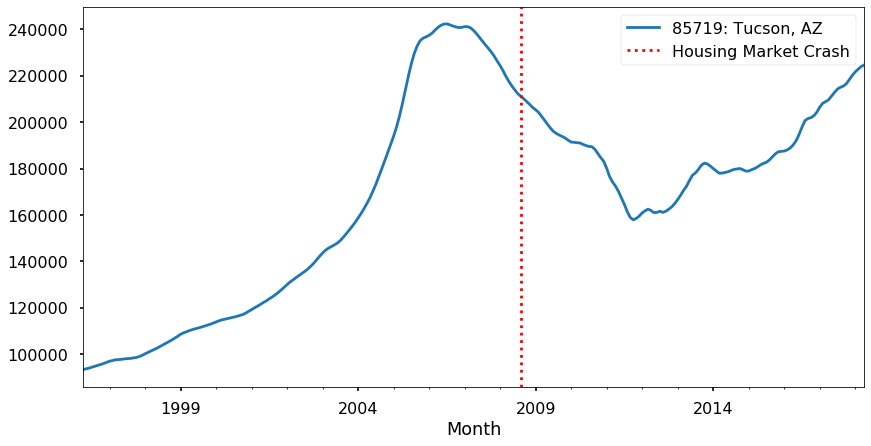

In [8]:
plot_ts([85719], show_crash=True)

# Eliminating Data I

For purposes of this project, we're going to move forward with data from 2010 onwards, as using pre-crash data would not only drastically increase our computing needs, but it's a reasonable assumption that it would also lead to somewhat unreliable predictions. However, we don't want to just use post-recovery data (2012 onwards), as the future predictions would be less conservative than we might want. Therefore, picking 2010 as our cutoff point is a decent combination of conservative estimation and computing power. 

In [9]:
df = df[df['Month'] > '2009-12-31']
df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
Month,,,,,,,,,
2010-01-01,84654,60657,Chicago,IL,Chicago,Cook,1,2010-01-01,775600.0
2010-01-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,2010-01-01,201300.0
2010-01-01,91982,77494,Katy,TX,Houston,Harris,3,2010-01-01,249200.0
2010-01-01,84616,60614,Chicago,IL,Chicago,Cook,4,2010-01-01,984100.0
2010-01-01,93144,79936,El Paso,TX,El Paso,El Paso,5,2010-01-01,117400.0


Let's isolate the same ZIP code from above as a time series.

In [10]:
ts = df.loc[df['ZipCode'] == 85719]['MeanValue'].rename(85719)
ts.name

85719

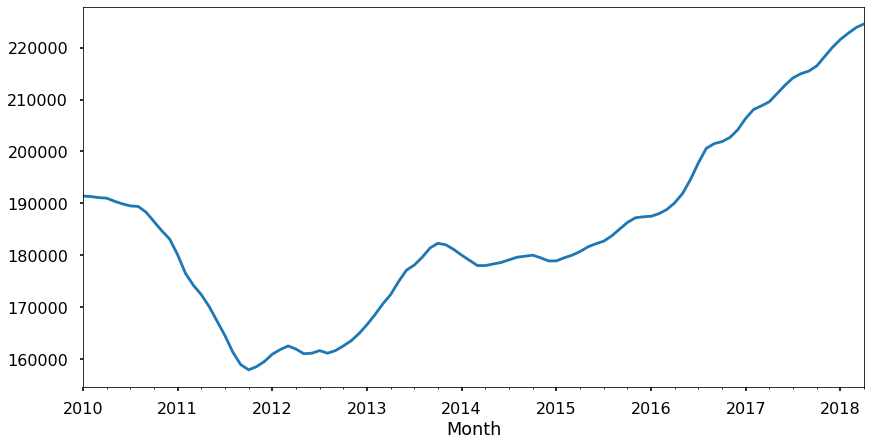

In [11]:
plt.rcParams['figure.figsize'] = (14, 7)

ts = ts.resample('MS').asfreq()
ts.plot();

Now that we've got our timetable down, let's eliminate any missing or null values.

In [12]:
df.isna().sum()

RegionID           0
ZipCode            0
City               0
State              0
Metro         102910
CountyName         0
SizeRank           0
Month              0
MeanValue          0
dtype: int64

In [13]:
df['Metro'].fillna('Missing',inplace=True)
df.isna().sum()

RegionID      0
ZipCode       0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
Month         0
MeanValue     0
dtype: int64

# Eliminating Data II

As time series modeling is extremely sensitive to missing data, we want to isolate our dataframe such that it contains only those ZIP codes that have no missing data throughout the entirety of our timeframe. Let's see how much of our data we're cutting out, just in case it's a huge percentage.

In [14]:
zipcodes = list(df[df['Month'] == '2010-01-01']['ZipCode'].unique())
print(len(zipcodes)/(df['ZipCode'].nunique()))

0.9606737757250561


We'll be left with 96% of unique ZIP codes, which is a large enough percentage that we can move forward.

In [15]:
for zipcode in df['ZipCode'].unique():
    if zipcode not in zipcodes:
        df = df[df['ZipCode'] != zipcode]
        
df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
Month,,,,,,,,,
2010-01-01,84654,60657,Chicago,IL,Chicago,Cook,1,2010-01-01,775600.0
2010-01-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,2010-01-01,201300.0
2010-01-01,91982,77494,Katy,TX,Houston,Harris,3,2010-01-01,249200.0
2010-01-01,84616,60614,Chicago,IL,Chicago,Cook,4,2010-01-01,984100.0
2010-01-01,93144,79936,El Paso,TX,El Paso,El Paso,5,2010-01-01,117400.0


As we've cut out all ZIP codes with fewer than 100 months' worth of data, we should have 100 months x 14,144 ZIP codes = 1,414,400 rows of data. 

In [16]:
len(df)

1414400

# ARIMA Modeling

Now we're ready for our ARIMA modeling, but first we have to choose which one. Do we run SARIMAX or ARIMA proper? To help us answer this question, we'll plot our ACF and PACF.

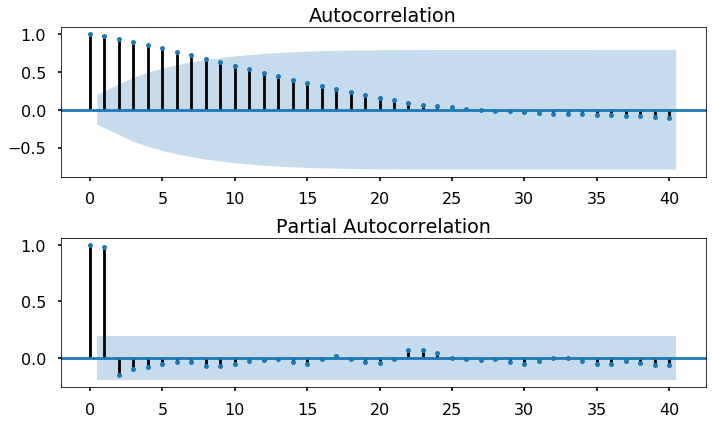

In [17]:
from  statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig,ax = plt.subplots(nrows=2,figsize=(10,6))

plot_acf(ts,ax=ax[0],lags=40);
plot_pacf(ts, ax=ax[1],lags=40);
plt.tight_layout()

If this were just AutoRegressive, the ACF would tail off, and PACF would cut off. If it were just a Moving Average, the ACF would cut off and the PACF would tail off. If it were ARMA, both ACF and PACF would tail off. Additionally, this time series could use at least one order of differencing. Given those statements, this looks sort of like simply AutoRegressive, but let's do a seasonal decomposition just to check.

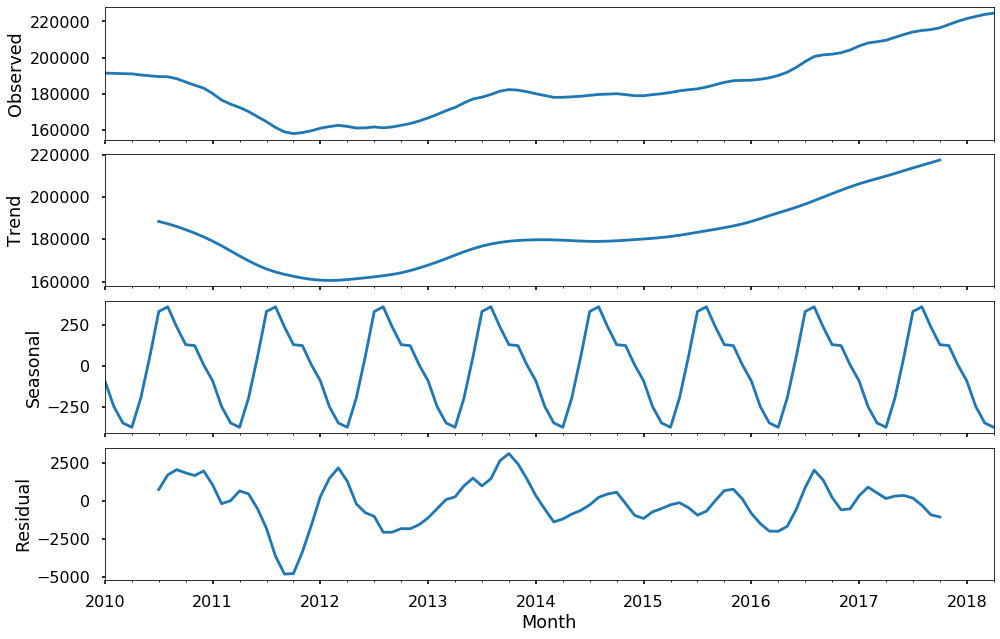

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = (14, 9)

seasonal_decompose(ts).plot();

Just as expected, the seasonal component is +/-250 dollars, whereas our data ranges from \\$160,000 to \\$220,000. To save on computing power, we'll run a regular ARIMA model with one order of differencing, as the seasonal component makes such a miniscule difference that the tradeoff is not worth it.

# Function Junction

Let's create a series of helper functions that will be responsible for train-test splitting, gridsearching for an ARIMA model, running diagnostics on the best model, and using the best model for predicting future data. 

## Train-Test with Gridsearch

First we'll need a couple of functions that will split our data, and grid search for the best pdq values. 

In [19]:
def get_train_test(ts, test_size=0.1):
    
    """Takes in a time series and returns a train-test split."""
    
    import math
    
    ts_split = math.floor(len(ts.index) * (1-test_size))

    ts_train = ts.iloc[:ts_split]
    ts_test = ts.iloc[ts_split:]
    
    return ts_train, ts_test


def grid_search(ts, p=range(6), d=[1], q=range(6), 
                include_dataframe=False):
    
    """Takes in a time series, a test size, and lists
    for pdq values to gridsearch for the best ARIMA model."""
    
    import itertools
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import warnings
    warnings.filterwarnings('ignore')
    
    ts_train, ts_test = get_train_test(ts)
    
    results = []
    combinations = list(itertools.product(p, d, q))

    for comb in combinations:
        try:
            model = SARIMAX(ts_train, order=comb, 
                            enforce_stationarity=False, 
                            enforce_invertibility=False)
            output = model.fit()
            results.append([comb, output.aic])
        except:
            continue
    
    df_results = pd.DataFrame(results, columns=['pdq', 'AIC'])
    best_pdq = df_results[df_results['AIC'] == df_results['AIC'].min()]['pdq']
    
    if include_dataframe:
        
        display(df_results.sort_values('AIC'))
    
    return best_pdq.values[0]

In [20]:
ts_train, ts_test = get_train_test(ts)
pdq = grid_search(ts, include_dataframe=True)
pdq

,pdq,AIC
17,"(2, 1, 5)",1284.033499
23,"(3, 1, 5)",1285.617811
29,"(4, 1, 5)",1287.494589
35,"(5, 1, 5)",1287.614674
5,"(0, 1, 5)",1291.869487
11,"(1, 1, 5)",1292.564306
16,"(2, 1, 4)",1296.489289
22,"(3, 1, 4)",1298.392083
28,"(4, 1, 4)",1299.691868
33,"(5, 1, 3)",1300.980789


(2, 1, 5)

## Creating Model Output and Diagnostics

Now we'll write a function that takes in our `best_pdq` tuple and outputs the corresponding model object. Optionally, this function will also output the model's summary and diagnostics.

In [21]:
def model_output(ts, pdq, plot=False, predict='test'):
    
    """Takes in a time series and a tuple of pdq values, and returns
    a SARIMAXResultsWrapper object. Optionally returns output of 
    SARIMAX().fit().plot_diagnostics() and SARIMAX().fit().summary()."""
    
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    
    if predict == 'test':
        
        #train-test split and use given pdq combination on train
        #data to predict test data. used for model evaluation.
        
        ts_train, ts_test = get_train_test(ts, test_size=0.1)
        
        model = SARIMAX(ts_train, order=pdq,
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
    
        
    if predict == 'future':
        
        #use given pdq combination on entire time series to 
        #generate a model that will be used to make predictions 
        #beyond test data.
        
        model = SARIMAX(ts, order=pdq,
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        
    output = model.fit()        
    
    if plot:
        display(output.summary())
        output.plot_diagnostics(figsize=(12,8));
        plt.tight_layout()
    
    return output

## Prediction Generation

Next, we need a function that takes in our time series and our model object from the previous function, and outputs the actual values predicted by the model. This function will either compare its training predictions to the test data, or will make future predictions based on the entire time series. As an option, the function will also plot the predicted data in conjunction with the given data.

In [22]:
def get_predictions(ts, model_output, show_plot=False,
                    predict='test'):
    
    """Takes in a time series and a SARIMAXResultsWrapper object, 
    and outputs a dataframe of predicted values spanning 1 year
    from end of test data."""
    
    #if we wish to compare predictions against test data, 
    #set predict to 'test'
    
    if predict == 'test': 
        
        ts_train, ts_test = get_train_test(ts)
        
        prediction = model_output.get_prediction(start=ts_test.index[0],
                                                 end=ts_test.index[-1], 
                                                 dynamic=True)
        
        #store prediction results and identification information in a 
        #pandas dataframe object to be returned.
        
        df_pred = prediction.conf_int()
        df_pred['predicted_mean'] = prediction.predicted_mean
        df_pred['city'] = df[df['ZipCode'] == ts.name]['City']
        df_pred['state'] = df[df['ZipCode'] == ts.name]['State']
        
        if show_plot:
            df_plot = pd.concat([df_pred,ts_train], axis=1)
        
            fig, ax = plt.subplots(figsize=(13,8))
            ts_train.plot(ax=ax,label='Training Data')
            ts_test.plot(ax=ax,label='Test Data')
            df_pred['predicted_mean'].plot(ax=ax, label='Predicted', color='g')
            ax.fill_between(df_pred.index, df_pred[f'lower {ts.name}'],
                            df_pred[f'upper {ts.name}'], color="k", alpha=.15,
                            label = '95% Confidence Interval')
            ax.legend()
            ax.set(title=f"Predictions for {ts.name}")
            plt.show()
        
    #if we wish to use our model to forecast 1 year in the future,
    #set predict to 'future'
    
    if predict == 'future':
        
        prediction = model_output.get_prediction(start=ts.index[-1],
                                                 end=ts.index.shift(12)[-1], 
                                                 dynamic=True)
        df_pred = prediction.conf_int()
        df_pred['predicted_mean'] = prediction.predicted_mean
        df_pred['city'] = df[df['ZipCode'] == ts.name]['City']
        df_pred['state'] = df[df['ZipCode'] == ts.name]['State']
    
        predicted_roi = round(((df_pred['predicted_mean'][-1] - ts[-1])/ts[-1])*100, 2)
        
        if show_plot:
            df_plot = pd.concat([df_pred, ts], axis=1)
        
            fig, ax = plt.subplots(figsize=(13,8))
            ts.plot(ax=ax,label='Actual Data')
            df_pred['predicted_mean'].plot(ax=ax, label='Predicted', color='g')
            ax.fill_between(df_pred.index, df_pred[f'lower {ts.name}'],
                            df_pred[f'upper {ts.name}'], color="k", alpha=.15,
                            label = '95% Confidence Interval')
            ax.legend()
            ax.set(title=f"Predictions for {ts.name} (ROI: {predicted_roi}%)")
            plt.show()
        
    return df_pred

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  85719   No. Observations:                   90
Model:               SARIMAX(2, 1, 5)   Log Likelihood                -634.017
Date:                Thu, 23 Jan 2020   AIC                           1284.033
Time:                        11:07:26   BIC                           1303.384
Sample:                    01-01-2010   HQIC                          1291.808
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3829      0.142      2.691      0.007       0.104       0.662
ar.L2          0.4202      0.158      2.655      0.008       0.110       0.730
ma.L1          1.2471      2.386      0.523      0.601      -3.429       5.923
ma.L2          0.2841      1.534      0.185      0.853      -2.723       3.291
ma.L3         -0.2400      0.987     -0.243      0.808      -2.174       1.694
ma.L4          0.0892      0.476      0.188      0.851      -0.843       1.021
ma.L5         -0.0541      0.182     -0.296      0.767      -0.412       0.303
sigma2      2.417e+05    6.9e+05      0.351      0.726   -1.11e+06    1.59e+06
===================================================================================
Ljung-Box (Q):                       21.21   Jarque-Bera (JB):                 1.53
Prob(Q):                              0.99   Prob(JB):                         0.47
Heteroskedasticity (H):               0.62   Skew:                            -0.33
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

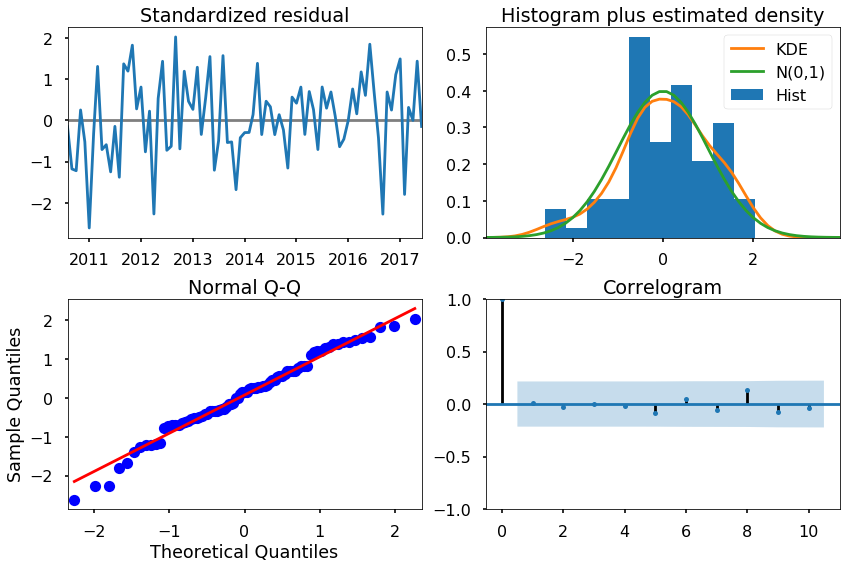

In [23]:
# testing model_output and get_predictions on 85719 using train-test split option

output = model_output(ts, pdq, plot=True, predict='test')

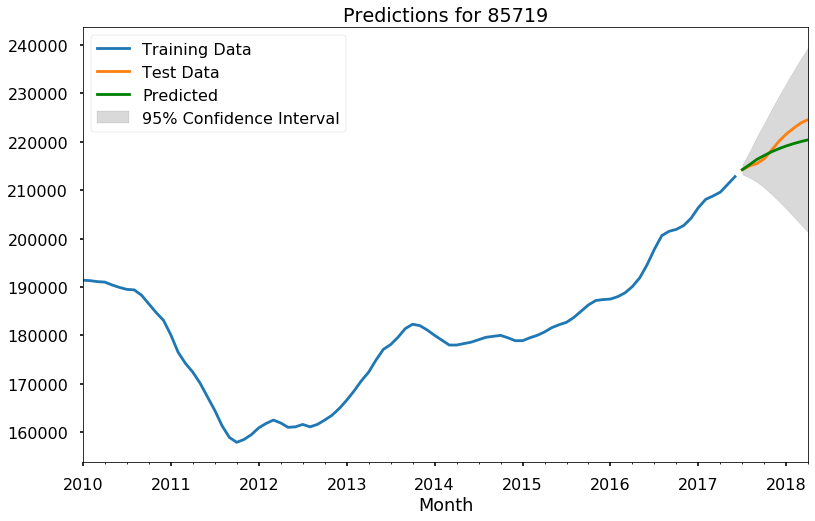

,lower 85719,upper 85719,predicted_mean,city,state
2017-07-01,213275.854288,215224.140447,214249.997367,Tucson,AZ
2017-08-01,212559.309033,218006.641095,215282.975064,Tucson,AZ
2017-09-01,211675.876466,221057.398991,216366.637728,Tucson,AZ
2017-10-01,210502.581853,223840.359739,217171.470796,Tucson,AZ
2017-11-01,209157.447017,226720.396772,217938.921895,Tucson,AZ
2017-12-01,207692.247287,229449.722795,218570.985041,Tucson,AZ
2018-01-01,206144.198471,232126.805828,219135.502149,Tucson,AZ
2018-02-01,204536.285083,234698.238270,219617.261676,Tucson,AZ
2018-03-01,202892.633167,237185.266196,220038.949681,Tucson,AZ
2018-04-01,201227.802124,239577.916876,220402.859500,Tucson,AZ


In [24]:
df_pred = get_predictions(ts, model_output=output, show_plot=True, predict='test')
df_pred

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  85719   No. Observations:                  100
Model:               SARIMAX(2, 1, 5)   Log Likelihood                -708.271
Date:                Thu, 23 Jan 2020   AIC                           1432.543
Time:                        11:07:26   BIC                           1452.804
Sample:                    01-01-2010   HQIC                          1440.723
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3779      0.134      2.819      0.005       0.115       0.641
ar.L2          0.4275      0.145      2.949      0.003       0.143       0.712
ma.L1          1.2721      0.248      5.120      0.000       0.785       1.759
ma.L2          0.2901      0.299      0.970      0.332      -0.296       0.876
ma.L3         -0.2667      0.314     -0.849      0.396      -0.882       0.349
ma.L4          0.0821      0.233      0.352      0.725      -0.375       0.540
ma.L5         -0.0605      0.083     -0.727      0.467      -0.223       0.102
sigma2      2.159e+05    4.1e+04      5.267      0.000    1.36e+05    2.96e+05
===================================================================================
Ljung-Box (Q):                       21.62   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.99   Prob(JB):                         0.51
Heteroskedasticity (H):               0.67   Skew:                            -0.29
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

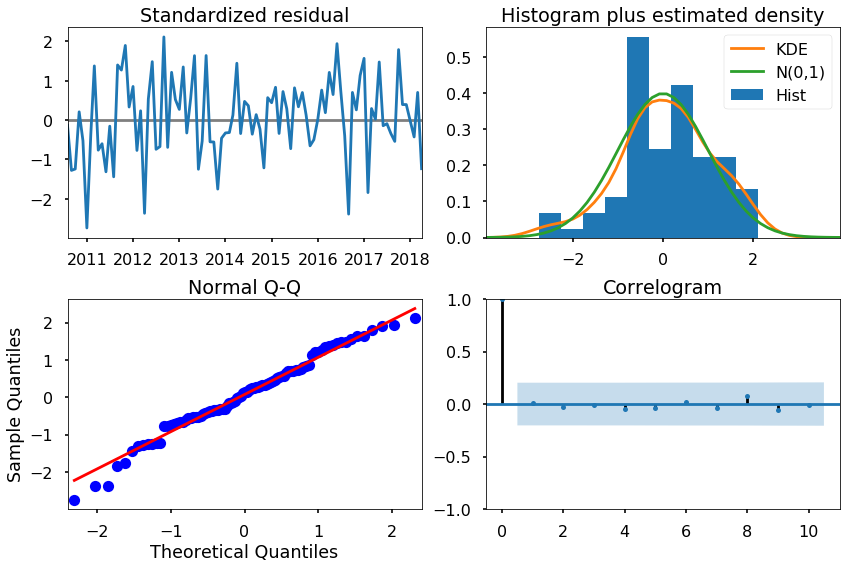

In [25]:
#testing model_output and get_predictions using the entire time series to generate predictions

output = model_output(ts, pdq, plot=True, predict='future')

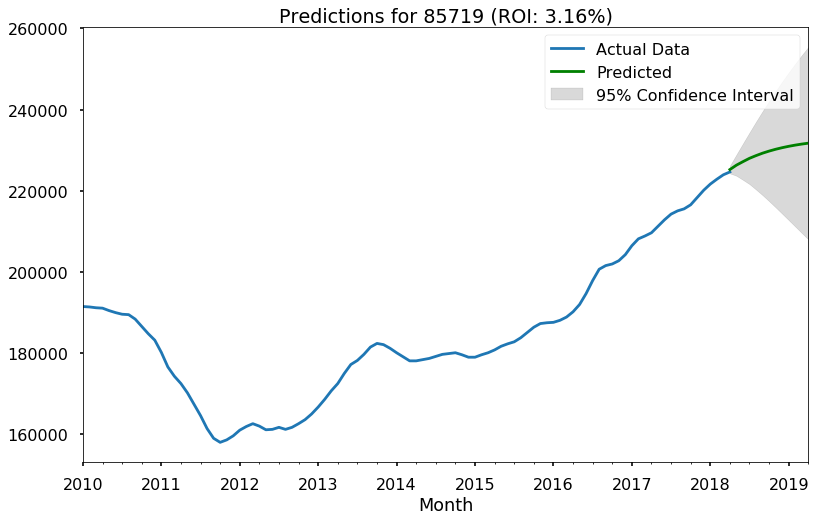

,lower 85719,upper 85719,predicted_mean,city,state
2018-04-01,224251.401923,226133.201438,225192.301680,Tucson,AZ
2018-05-01,223660.616054,228890.152530,226275.384292,NaN,NaN
2018-06-01,222652.169528,231628.593883,227140.381705,NaN,NaN
2018-07-01,221599.755426,234333.848621,227966.802024,NaN,NaN
2018-08-01,220261.660022,236997.893965,228629.776993,NaN,NaN
2018-09-01,218882.068465,239585.177413,229233.622939,NaN,NaN
2018-10-01,217395.679048,242094.823209,229745.251128,NaN,NaN
2018-11-01,215870.896714,244522.603374,230196.750044,NaN,NaN
2018-12-01,214306.052158,246866.151955,230586.102057,NaN,NaN
2019-01-01,212725.842763,249126.681332,230926.262048,NaN,NaN


In [26]:
df_pred = get_predictions(ts, model_output=output, show_plot=True, predict='future')
df_pred

## Model Evaluation

We'll need a function to evaluate the models we create for each ZIP code. Below is a function that will return a dataframe of four goodness-of-fit metrics: MSE, RMSE, R-squared, and [Theil's U](https://docs.oracle.com/cd/E57185_01/CBREG/ch06s02s03s04.html). For the latter, we'll need to write the function from scratch, as it is not included in `sklearn.metrics`.

Note that the `evaluate_model` function only works on `output` and `df_pred` objects obtained from running `model_output` and `get_predictions` with ```predict='test'```.

In [27]:
def get_theils_u(y_true, y_pred):
    
    """Returns Theil's U statistic for model validation."""
    
    nums = []
    denoms = []
    
    for i in range(len(y_true) - 1):
        num = (y_pred[i + 1] - y_true[i + 1])/y_true[i]
        nums.append([num ** 2])
        denom = (y_true[i + 1] - y_true[i])/y_true[i]
        denoms.append([denom ** 2])
        
    u = np.sqrt(np.sum(nums) / np.sum(denoms))
    return u

def evaluate_model(ts_true, ts_pred):
    
    """Takes in a series of actual data, and a series of 
    predicted data, and outputs model statistics."""
    
    from sklearn.metrics import mean_squared_error, r2_score
    
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(ts_true, ts_pred)
    u = get_theils_u(ts_true, ts_pred)

    evaluation = pd.DataFrame({'Metric': ['MSE','RMSE','R2',"Theil's U"],
                               'Value': [mse,rmse,r2,u]})
    
    return evaluation

In [28]:
pd.options.display.float_format = '{:.2f}'.format
ts = df.loc[df['ZipCode'] == 85719]['MeanValue'].rename(85719)
ts = ts.resample('MS').asfreq()
output = model_output(ts, pdq, predict='test')
df_pred = get_predictions(ts, model_output=output, predict='test')

evaluate_model(ts_test, df_pred['predicted_mean'])

,Metric,Value
0,MSE,5248004.36
1,RMSE,2290.85
2,R2,0.61
3,Theil's U,1.92


## Obtaining ROI and Overall Score

Finally, we'll need to write a function that returns the results of running our data through the equation described in the Business Case. For convenience, here it is again:

$$\large \text{Score} = \begin{cases}\dfrac{10R}{\log(P_H-P_L+2)}, & \text{if } R>0, \newline
\phantom{----}R, & \text{if } R\leq 0.\end{cases}$$

The following function will return the value for $R$ and the corresponding value for Score, the two numbers on which business recommendations will be made.

In [29]:
def get_score_roi(ts, df_pred):
    
    predicted_roi = round(((df_pred['predicted_mean'][-1] - ts[-1])/ts[-1])*100, 2)
    
    if predicted_roi <= 0:
        score = predicted_roi
    
    else:
        num = 10 * predicted_roi
        denom = np.log(df_pred[f"upper {ts.name}"][-1] - df_pred[f"lower {ts.name}"][-1] + 2)
    
        score = num / denom
        
    return predicted_roi, score

In [30]:
#testing get_score_roi on ZIP 85719

output = model_output(ts, pdq, predict='future')
df_pred = get_predictions(ts, model_output=output, predict='future')
get_score_roi(ts, df_pred)

(3.16, 2.934739700477313)

# Putting it All Together

Now that we're done writing functions, it's time to use them to transform our data into actionable intelligence. Below is a test of all of our functions on a small subset of the data, as proof-of-concept of the workflow.

In [32]:
#testing entire workflow on 5 ZIPs

list_roi_score = []

for zipcode in list(df[(df['Metro'] == 'Tucson') & (df['State'] == 'AZ')]['ZipCode'].unique()[:5]):
    ts_ = df[df['ZipCode'] == zipcode]['MeanValue'].rename(zipcode)
    ts_ = ts_.resample('MS').asfreq()
    pdq = grid_search(ts_)
    output = model_output(ts_, pdq, predict='future')
    df_pred = get_predictions(ts_, output, predict='future')
    roi, score = get_score_roi(ts_, df_pred)
    investment = ts_[-1]
    profit = investment * roi / 100
    list_roi_score.append([zipcode,
                           roi, 
                           score,
                           pdq,
                           output.aic,
                           investment,
                           profit
                            ])
    
list_roi_score

[[85710,
  4.98,
  4.753120509457564,
  (1, 1, 5),
  1371.1627698048242,
  180600.0,
  8993.880000000001],
 [85705,
  3.26,
  3.126274986668906,
  (4, 1, 5),
  1364.4534743745,
  147700.0,
  4815.0199999999995],
 [85711,
  8.43,
  7.992600197732552,
  (1, 1, 5),
  1364.0260686297845,
  161000.0,
  13572.3],
 [85719,
  3.16,
  2.934739700477313,
  (2, 1, 5),
  1432.5427666845171,
  224600.0,
  7097.36],
 [85706,
  9.59,
  9.15706993567488,
  (1, 1, 5),
  1377.5081639207262,
  137200.0,
  13157.48]]

In [33]:
score_df_ = pd.DataFrame(list_roi_score, columns=['Zip',
                                                  'ROI',
                                                  'Score',
                                                  'PDQ',
                                                  'AIC',
                                                  'Initial Investment',
                                                  '1-Year Profit'])
score_df_

,Zip,ROI,Score,PDQ,AIC,Initial Investment,1-Year Profit
0,85710,4.98,4.75,"(1, 1, 5)",1371.16,180600.00,8993.88
1,85705,3.26,3.13,"(4, 1, 5)",1364.45,147700.00,4815.02
2,85711,8.43,7.99,"(1, 1, 5)",1364.03,161000.00,13572.30
3,85719,3.16,2.93,"(2, 1, 5)",1432.54,224600.00,7097.36
4,85706,9.59,9.16,"(1, 1, 5)",1377.51,137200.00,13157.48


# Eliminating Data III

Obtaining `list_roi_score` took roughly 19.8 seconds to run for 5 ZIP codes. At that rate, it would take over 15.5 hours to run all 14,144 ZIPs in our dataframe! Since this is rather infeasible, we'll look to collect further domain knowledge. 

For this task, we'll be looking at [this article](https://www.businessinsider.com/best-places-to-invest-in-real-estate-in-the-us-2019-7), which gives ten metro areas that Zillow predicts to have the highest growth. Further narrowing our scope in this way will decrease computational resources while also making the information gleaned from this project much more palatable.

In [34]:
metros = {'Tampa': 'FL','Las Vegas': 'NV','Phoenix': 'AZ','Atlanta': 'GA','Orlando': 'FL','Miami-Fort Lauderdale': 'FL',
          'Detroit': 'MI','Dallas-Fort Worth': 'TX','Nashville': 'TN','Charlotte': 'NC'}

total_length = 0
for key in metros:
    total_length += len(df[(df['Metro'] == key) & (df['State'] == metros[key])])
    
# return total_length divided by 100 months per ZIP code to get total number of ZIP codes
    
total_length/100

1208.0

At the same processing rate, 1,208 ZIPs will take one hour and twenty minutes. As this time frame is deemed appropriate for the scope of this project, the below cell will be run. At the end of the process, the resulting dataframe will be saved to a pickle file for easy retrieval.

In [35]:
list_roi_score = []

for city in metros:
    for zipcode in list(df[(df['Metro'] == city) & (df['State'] == metros[city])]['ZipCode'].unique()):
        ts_ = df[df['ZipCode'] == zipcode]['MeanValue'].rename(zipcode)
        ts_ = ts_.resample('MS').asfreq()
        pdq = grid_search(ts_)
        output = model_output(ts_, pdq, predict='future')
        df_pred = get_predictions(ts_, output, predict='future')
        roi, score = get_score_roi(ts_, df_pred)
        investment = ts_[-1]
        profit = investment * roi / 100
        list_roi_score.append([city,
                               zipcode,
                               roi, 
                               score,
                               pdq.values[0],
                               output.aic,
                               investment,
                               profit
                              ])
        
score_df = pd.DataFrame(list_roi_score, columns=['City',
                                                 'Zip',
                                                 'ROI',
                                                 'Score',
                                                 'PDQ',
                                                 'AIC',
                                                 'Initial Investment',
                                                 '1-Year Profit'])

score_df.to_pickle('score_df.pickle')

# Analyzing Results

The above cell takes over one hour to run, so for convenience, the pickle file is accessible by running the following block of code.

In [35]:
score_df = pd.read_pickle('score_df.pickle')
score_df.head()

,City,Zip,ROI,Score,PDQ,AIC,Initial Investment,1-Year Profit
0,Tampa,33647,3.50,3.31,"(2, 1, 5)",1429.49,295700.00,10349.50
1,Tampa,33511,4.72,4.42,"(5, 1, 5)",1397.53,209700.00,9897.84
2,Tampa,34668,18.63,18.09,"(5, 1, 5)",1323.40,107700.00,20064.51
3,Tampa,34698,16.16,15.14,"(1, 1, 5)",1419.56,262100.00,42355.36
4,Tampa,33578,3.99,3.76,"(1, 1, 5)",1393.42,198800.00,7932.12


We should have 1,208 rows, or one row for every ZIP code:

In [36]:
len(score_df)

1208

Finally, here is the list of top ten predicted ZIP codes in which to invest, ranked by highest score to lowest:

In [37]:
score_df.sort_values('Score', ascending=False).head(10)

,City,Zip,ROI,Score,PDQ,AIC,Initial Investment,1-Year Profit
966,Dallas-Fort Worth,76114,35.18,34.75,"(1, 1, 5)",1386.02,137000.00,48196.60
45,Tampa,34691,32.85,32.20,"(1, 1, 5)",1337.44,104800.00,34426.80
29,Tampa,34652,33.34,32.19,"(3, 1, 5)",1335.76,114400.00,38140.96
1159,Charlotte,28208,30.39,29.98,"(1, 1, 5)",1432.94,113400.00,34462.26
1121,Nashville,37085,30.38,29.80,"(1, 1, 5)",1445.61,290900.00,88375.42
986,Dallas-Fort Worth,76009,29.37,27.95,"(1, 1, 5)",1458.89,165200.00,48519.24
90,Tampa,34690,27.14,26.23,"(4, 1, 5)",1327.62,88100.00,23910.34
851,Dallas-Fort Worth,75217,24.70,25.23,"(1, 1, 5)",1401.65,111300.00,27491.10
614,Miami-Fort Lauderdale,33069,24.94,24.73,"(1, 1, 5)",1389.13,170300.00,42472.82
1022,Dallas-Fort Worth,75233,26.83,24.53,"(1, 1, 5)",1438.76,204100.00,54760.03


Side note: It is interesting to note that nearly every PDQ combination in this list is (1, 1, 5). ARIMA models with this configuration are of the [damped-trend linear exponential smoothing variety](https://www.bauer.uh.edu/gardner/docs/pdf/Damped-trend-Modelling.pdf). 

In [38]:
score_df.drop(columns=['PDQ','AIC']).sort_values('Score', ascending=False).reset_index(drop=True).head()

,City,Zip,ROI,Score,Initial Investment,1-Year Profit
0,Dallas-Fort Worth,76114,35.18,34.75,137000.00,48196.60
1,Tampa,34691,32.85,32.20,104800.00,34426.80
2,Tampa,34652,33.34,32.19,114400.00,38140.96
3,Charlotte,28208,30.39,29.98,113400.00,34462.26
4,Nashville,37085,30.38,29.80,290900.00,88375.42


## How Close Did We Get?

For our top 5, let's run our `evaluate_model` function in order to quantify how close we got to the test data. Given the nature of damped-trend linear exponential smoothing models, we should generally expect to see more conservative estimates than the test data might show; however, literature supports the usage of such models for longer-term predictions.

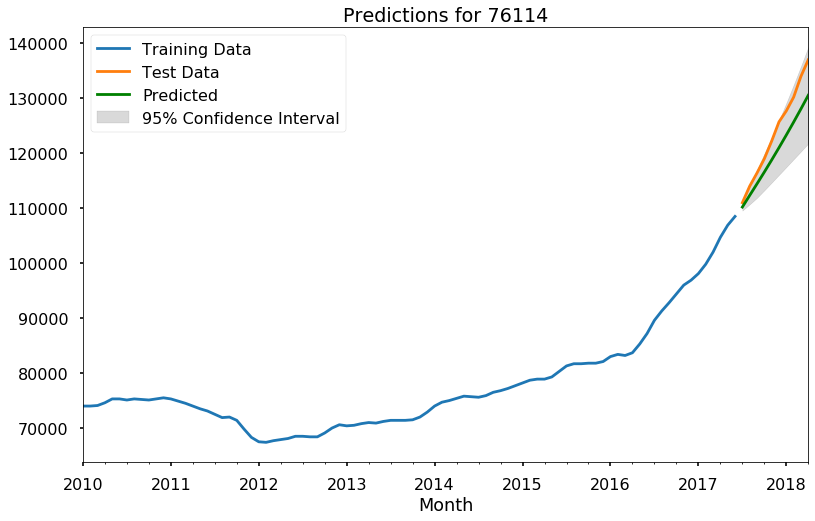

,Metric,Value
0,MSE,16351679.56
1,RMSE,4043.72
2,R2,0.76
3,Theil's U,1.40


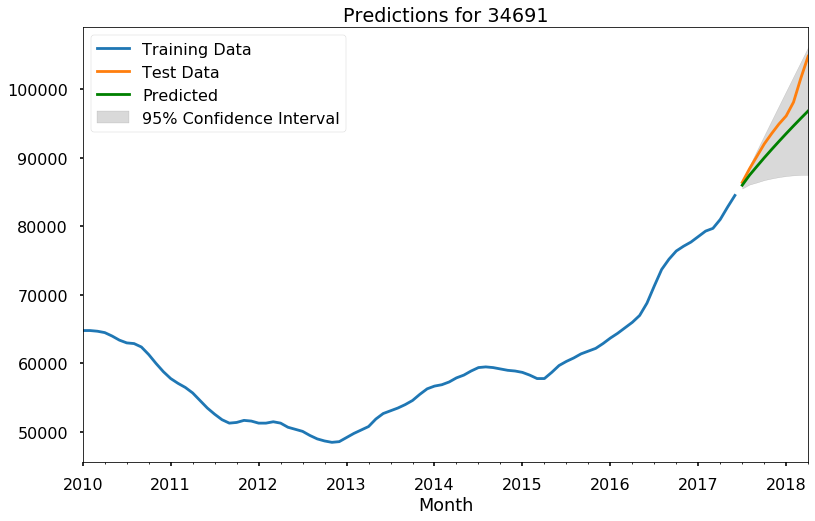

,Metric,Value
0,MSE,13544838.51
1,RMSE,3680.33
2,R2,0.55
3,Theil's U,1.73


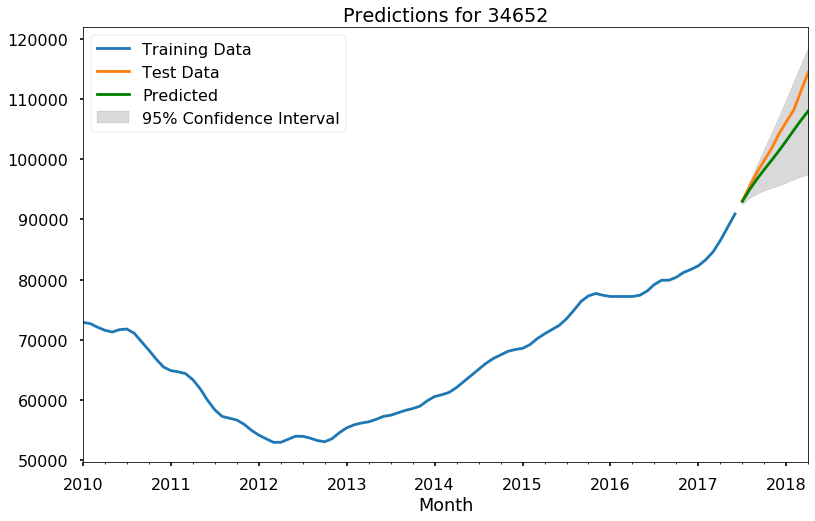

,Metric,Value
0,MSE,10122590.62
1,RMSE,3181.60
2,R2,0.76
3,Theil's U,1.33


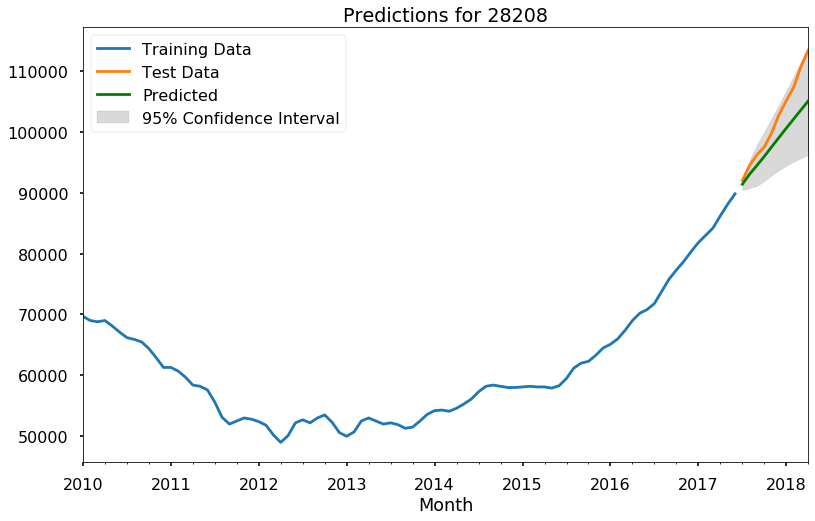

,Metric,Value
0,MSE,19487171.34
1,RMSE,4414.43
2,R2,0.58
3,Theil's U,1.81


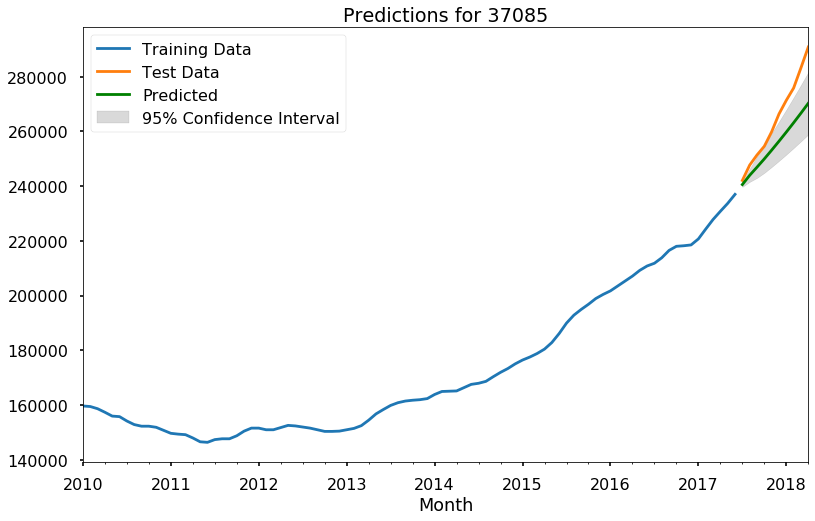

,Metric,Value
0,MSE,119711559.61
1,RMSE,10941.28
2,R2,0.48
3,Theil's U,1.99


In [39]:
for zipcode in score_df.sort_values('Score', ascending=False)['Zip'].head():

    ts = df.loc[df['ZipCode'] == zipcode]['MeanValue'].rename(zipcode)
    ts = ts.resample('MS').asfreq()
    ts_train, ts_test = get_train_test(ts)
    
    pdq = score_df[score_df['Zip'] == zipcode]['PDQ'].values[0]

    model = model_output(ts, pdq, predict='test')
    df_pred = get_predictions(ts, model, show_plot=True,
                              predict='test')
    
    display(evaluate_model(ts_test, df_pred['predicted_mean']))

Interestingly enough, our R-squared values for the top 5 range from 0.48 to 0.76, with no model producing Theil's U within the acceptable confidence range. 

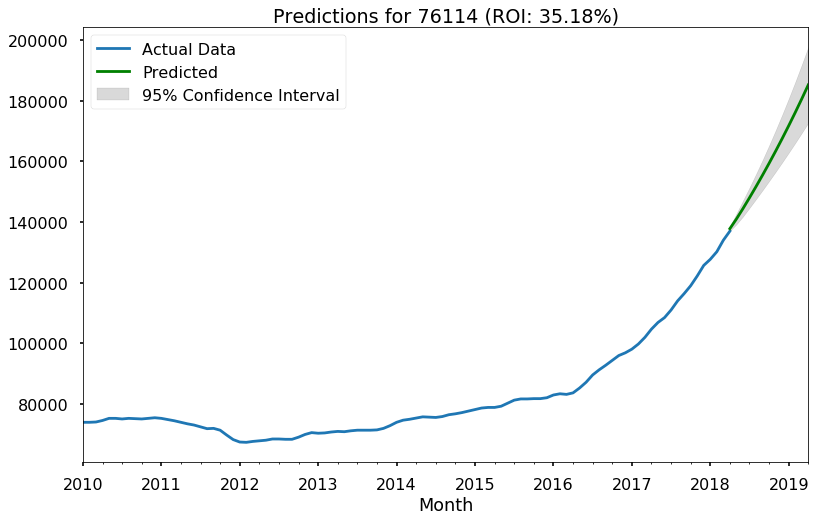

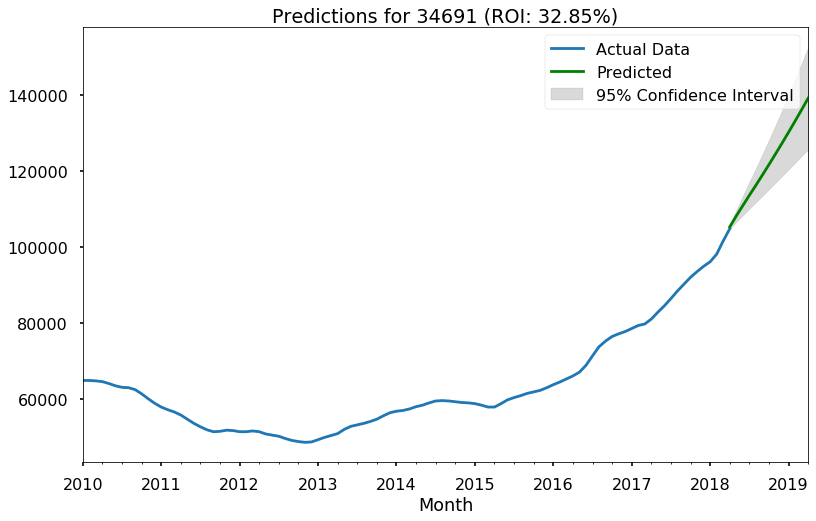

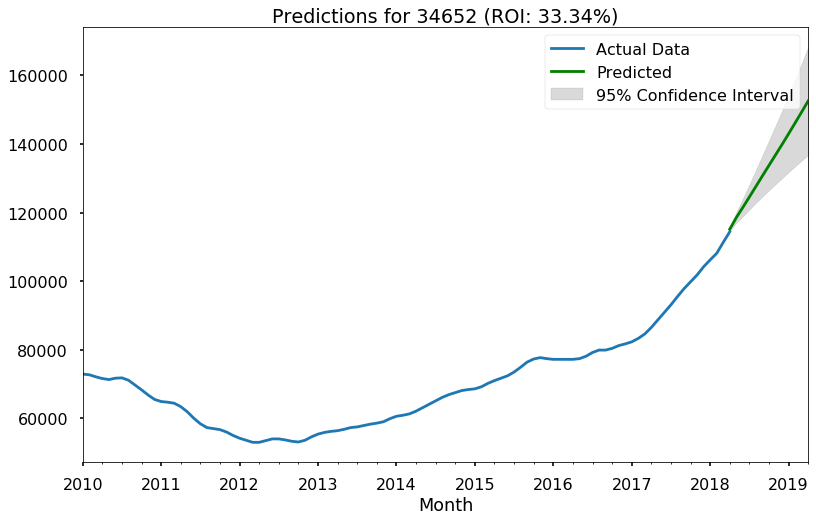

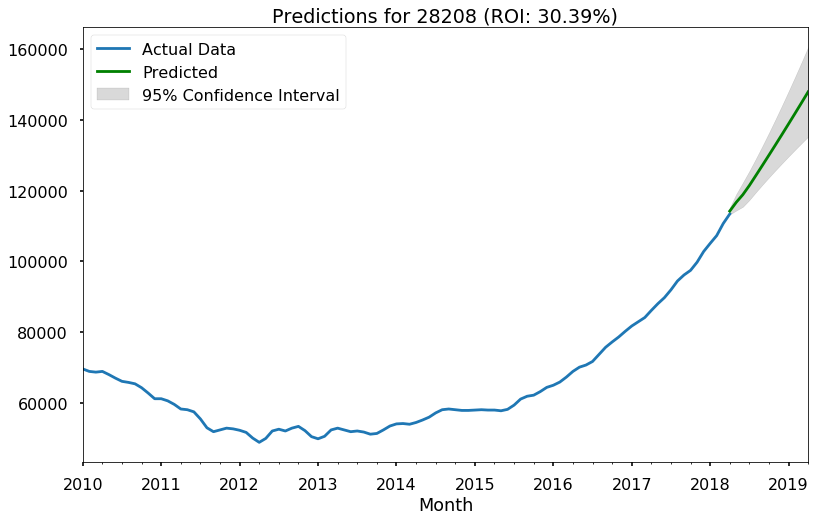

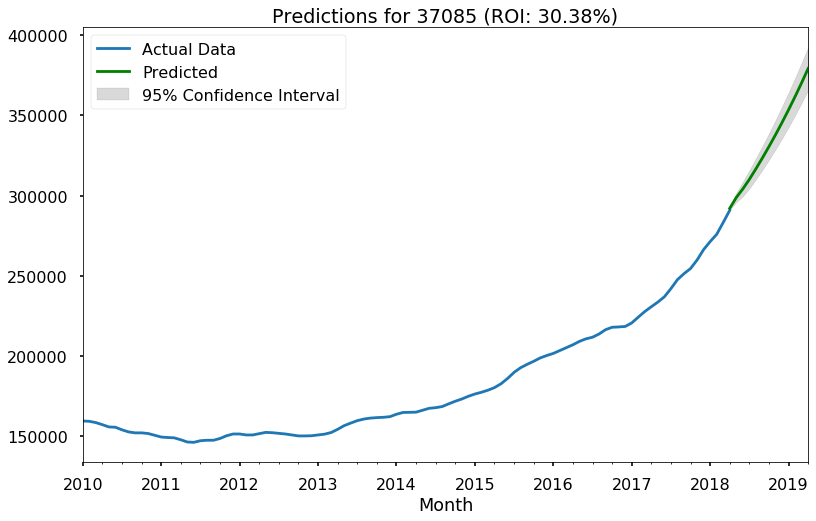

In [40]:
for zipcode in score_df.sort_values('Score', ascending=False)['Zip'].head():

    ts = df.loc[df['ZipCode'] == zipcode]['MeanValue'].rename(zipcode)
    ts = ts.resample('MS').asfreq()
    pdq = score_df[score_df['Zip'] == zipcode]['PDQ'].values[0]

    model = model_output(ts, pdq, predict='future')
    get_predictions(ts, model, show_plot=True,
                    predict='future')

## Other Metrics for Determining "Best"

Of course, while Score is one of the more useful metrics for determining the best ZIP code, it is far from the only one. Below, we've ranked ZIP codes by their estimated profit after one year, as well as ranking by lowest initial investment. For the latter, we've only kept ZIP codes that have a positive score, and an ROI of at least 6%.

In [41]:
score_df.drop(columns=['PDQ','AIC']).sort_values('1-Year Profit', 
                                                 ascending=False).head()

,City,Zip,ROI,Score,Initial Investment,1-Year Profit
645,Miami-Fort Lauderdale,33480,4.02,2.96,4686200.00,188385.24
667,Miami-Fort Lauderdale,33316,14.77,11.83,1079800.00,159486.46
69,Tampa,33606,16.09,13.54,674600.00,108543.14
1175,Charlotte,28203,15.60,13.91,612100.00,95487.60
641,Miami-Fort Lauderdale,33301,7.98,6.42,1145800.00,91434.84


In [42]:
# the top five worst, just for completion's sake

score_df.drop(columns=['PDQ','AIC']).sort_values('1-Year Profit').head()

,City,Zip,ROI,Score,Initial Investment,1-Year Profit
668,Miami-Fort Lauderdale,33149,-9.56,-9.56,2871700.00,-274534.52
601,Miami-Fort Lauderdale,33140,-4.57,-4.57,1725600.00,-78859.92
275,Phoenix,85262,-3.32,-3.32,907500.00,-30129.00
533,Miami-Fort Lauderdale,33139,-0.84,-0.84,2914100.00,-24478.44
438,Atlanta,30625,-5.73,-5.73,267300.00,-15316.29


In [43]:
score_df[(score_df['Score'] > 0) & 
         (score_df['ROI'] >= 6)].drop(columns=['PDQ','AIC']).sort_values('Initial Investment').head()

,City,Zip,ROI,Score,Initial Investment,1-Year Profit
705,Detroit,48146,9.02,9.38,75000.00,6765.00
776,Detroit,48240,20.47,20.09,76800.00,15720.96
717,Detroit,48021,11.96,11.98,79100.00,9460.36
443,Atlanta,30216,17.67,17.25,82700.00,14613.09
1046,Dallas-Fort Worth,75453,8.22,8.72,85400.00,7019.88


# Conclusions

There are many potential definitions and metrics by which we can define and measure "best", and there are therefore many different "Top 5" lists that can be created, given the data. For this work, we have three separate lists depending on the investor's goals. 

## **For investors looking to maximize ROI and Confidence:**

In [44]:
score_df.drop(columns=['PDQ','AIC']).sort_values('Score', ascending=False).reset_index(drop=True).head()

,City,Zip,ROI,Score,Initial Investment,1-Year Profit
0,Dallas-Fort Worth,76114,35.18,34.75,137000.00,48196.60
1,Tampa,34691,32.85,32.20,104800.00,34426.80
2,Tampa,34652,33.34,32.19,114400.00,38140.96
3,Charlotte,28208,30.39,29.98,113400.00,34462.26
4,Nashville,37085,30.38,29.80,290900.00,88375.42


## **For investors looking to maximize their raw profit after one year:**

In [45]:
score_df.drop(columns=['PDQ','AIC']).sort_values('1-Year Profit', ascending=False).reset_index(drop=True).head()

,City,Zip,ROI,Score,Initial Investment,1-Year Profit
0,Miami-Fort Lauderdale,33480,4.02,2.96,4686200.00,188385.24
1,Miami-Fort Lauderdale,33316,14.77,11.83,1079800.00,159486.46
2,Tampa,33606,16.09,13.54,674600.00,108543.14
3,Charlotte,28203,15.60,13.91,612100.00,95487.60
4,Miami-Fort Lauderdale,33301,7.98,6.42,1145800.00,91434.84


## **For investors looking to minimize their initial investment while striving for a reasonable ROI:**

Note: ROIs of 6% or higher were considered "reasonable".

In [46]:
score_df[score_df['ROI'] >= 6].drop(columns=['PDQ','AIC']).sort_values('Initial Investment').reset_index(drop=True).head()

,City,Zip,ROI,Score,Initial Investment,1-Year Profit
0,Detroit,48146,9.02,9.38,75000.00,6765.00
1,Detroit,48240,20.47,20.09,76800.00,15720.96
2,Detroit,48021,11.96,11.98,79100.00,9460.36
3,Atlanta,30216,17.67,17.25,82700.00,14613.09
4,Dallas-Fort Worth,75453,8.22,8.72,85400.00,7019.88


# Appendix

In discussing how we arrived at the derivation of the Score heuristic, particularly the "penalty" for wide confidence bands, it is appropriate to note a few points about the source data.

$(1)$ $P_H$ and $P_L$ will always be non-negative integers. In other words:

$$\large \forall P_H \forall P_L,  \phantom{-}P_H, P_L \in \mathbb{N}$$

where $\mathbb{N}$ is the natural numbers set, rather than the prime numbers set.

$(2)$ $P_H$ will always be greater than or equal to $P_L$:

$$\large \forall P_H \forall P_L,\phantom{-}P_H\geq P_L $$

Thinking about what $P_H$ and $P_L$ stand for, both points make sense; after all, houses never sell for negative value, and confidence bands can never be negative, i.e. the highball estimate, by definition, will always be higher than the lowball estimate. This leads to our next point:

$(3)$ Given $(1)$ and $(2)$, $(P_H - P_L)$ will always be a non-negative integer:

$$\large \forall P_H \forall P_L,\phantom{-}(P_H - P_L) \in \mathbb{N}$$

Given $(3)$, the logarithm of $(P_H - P_L)$ for any $P_H$ and $P_L$ will be positive except for exactly two cases:

$$\large \log(P_H-P_L) = \begin{cases}-\infty, & \text{if } P_H-P_L = 0, \newline \phantom{-}0, & \text{if } P_H-P_L = 1, \newline >0, & \text{if } P_H-P_L>1.\end{cases}$$

Strictly speaking, we've defined $\log(0)$ as $\lim\limits_{x \to 0} \log(x) = -\infty$, but for practical purposes, we can consider the two to be equivalent. In either case, having $0$ or $-\infty$ in the denominator, while exceedingly rare, is counterproductive for the above work. Therefore, we add 2 to $(P_H-P_L)$ to prevent ever having to take the logarithm of 0 or 1. This addition affects every confidence band in the same macroscopic way: the narrower confidence bands will still have smaller denominators (and therefore higher scores) than the wider ones.

As for the numerator, every ROI (and therefore Score) is multipled by 10 to widen the range of values that the real data produced, so as to increase the palatability and level of interpretability of such a heuristic, particularly for the layman.

For the second case definition of Score, it's worth noting that ranking ZIP codes by the first case definition is inappropriate for those with negative predicted ROI, as a wide confidence band will increase the Score rather than decrease it as intended. For this reason, we rank ZIP codes with negative Score by their predicted ROI instead.

Given the above points, we can generalize the definition of Score as follows:

$$\large \text{Score} = \begin{cases}\dfrac{10R}{\log(P_H-P_L+2)}, & \text{if } R>0, \newline
\phantom{----}R, & \text{if } R\leq 0.\end{cases}$$

Given $(1)$, the function produced is, even in theory, discontinuous and not differentiable with respect to $R$ everywhere, due to the stepwise nature of $P_H$ and $P_L$. However, even if we were to allow $P_H$ and $P_L$ to be subsets of $\mathbb{R}$, rather than $\mathbb{N}$, the function, while made continuous, would still not be differentiable at $R=0$. 

The Score function certainly permits Score to be greater than $R$, and in fact many Scores were calculated as such in the empirical results. In the case where $P_H-P_L=0$, that is, when $P_H$ and $P_L$ are equal, Score reaches a maximal value of $\dfrac{10R}{\log(2)} \approx 14.4R$. 